In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import h5py
import matplotlib


## Nikhil's code

In [2]:
import os
import h5py
import os, errno
import matplotlib


def createFolder(folderPath):
    try:
        os.makedirs(folderPath)
        return True
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise


def get_data(index_of_key = 0, serial_num = 0, mode = 'train', hdf_path = None):
    """
    Parameters
    ----------
    index_key : INT, optional
        DESCRIPTION. Id of the person. There are 20 unique person in Train dataset. The default is 0.
    serial_num : INT, optional
        DESCRIPTION. Verey person has 100 different images. The default is 0.
    mode : STR, optional
        DESCRIPTION. The default is 'train'.

    Returns
    -------
    list of images.

    """
    AVAILABLE_GROUPS = ['eye-region', 'face', 'face-landmarks', 'gaze', 'head', 'left-eye', 'right-eye']
    
    if hdf_path is None:
        if mode == 'train':
            hdf_path = os.path.join( *['..', '..','data', 'mp19_train.h5'] )
        elif mode == 'test':
            hdf_path = os.path.join( *['..', '..','data', 'mp19_test_students.h5'] )
            AVAILABLE_GROUPS.remove('gaze')
        elif mode == 'valid' or mode == 'validation':
            hdf_path = os.path.join( *['..', '..','data', 'mp19_validation.h5'] )
        else:
            raise NameError('mode should be train/test/valid')
    
    hdf5 = h5py.File(hdf_path, 'r',libver='latest', swmr=True)
    hdf_keys = list(hdf5.keys())
    
    dicts = {}

    for grp in AVAILABLE_GROUPS:
#         dicts[grp] = hdf5.get( hdf_keys[index_of_key] + '/' + grp ).value[serial_num, ]
        dicts[grp] = hdf5.get( hdf_keys[index_of_key] + '/' + grp )[serial_num, ]
        
    return dicts




x = get_data(index_of_key = 0, serial_num = 0, mode = 'train', hdf_path = "../datasources/data_download/mp19_validation.h5")

In [3]:
x

{'eye-region': array([[[  8,   0,  14],
         [ 12,   0,  16],
         [ 20,   1,  20],
         ...,
         [186, 225, 255],
         [172, 212, 255],
         [156, 195, 255]],
 
        [[  9,   0,  13],
         [ 15,   0,  16],
         [ 24,   3,  22],
         ...,
         [181, 220, 255],
         [169, 209, 255],
         [157, 194, 255]],
 
        [[ 11,   0,  14],
         [ 18,   0,  18],
         [ 29,   8,  27],
         ...,
         [176, 213, 255],
         [168, 206, 255],
         [159, 198, 255]],
 
        ...,
 
        [[150, 125, 144],
         [156, 131, 150],
         [158, 130, 152],
         ...,
         [238, 255, 255],
         [235, 255, 255],
         [234, 255, 255]],
 
        [[156, 131, 150],
         [156, 131, 152],
         [152, 124, 147],
         ...,
         [240, 255, 255],
         [235, 255, 255],
         [234, 255, 255]],
 
        [[158, 131, 150],
         [158, 130, 152],
         [155, 127, 149],
         ...,
         [240,

### Getting one sample 

In [4]:
hdf_path = "../datasources/data_download/mp19_validation.h5"
hdf5 = h5py.File(hdf_path, 'r',libver='latest', swmr=True)


In [5]:
hdf_keys = list(hdf5.keys())

print(hdf5.get(hdf_keys[0])['face'].shape[0])

100


In [6]:
## extracting one sample by idx, this was used in DataLoader's __getitem__
idx = 150
landmarks = ['eye-region', 'face', 'face-landmarks', 'gaze', 'head', 'left-eye', 'right-eye']

person_len = len(hdf5)
samples_per_person_len = hdf5.get(hdf_keys[0])['face'].shape[0]
print(person_len, samples_per_person_len)

person_id = int(idx % person_len)
sample_num = int(idx / samples_per_person_len)

print(idx, person_id, sample_num)
sample = {}
sample['person_id'] = person_id
sample['sample_num'] = sample_num
for landmark in landmarks:
    sample[landmark] = hdf5.get(hdf_keys[person_id])[landmark][sample_num,]
    if(landmark == 'left-eye'):
        print(sample[landmark].shape)

40 100
150 30 1
(60, 90, 3)


## Dataset

In [43]:
#Derived from this discussion: https://discuss.pytorch.org/t/dataloader-when-num-worker-0-there-is-bug/25643/22
#Same old dataset
class HDF5Dataset(Dataset):
    """HDF5Dataset dataset. \
        author: Dusan Svilarkovic
    """

    def __init__(self, hdf_path, transform=None, use_colour = True, data_format = 'NCHW', preprocessing = True):
        """
        Args:
            hdf_path (string): Path to the hdf5 file with annotations.
            transform (callable, optional): Optional transform to be applied
                on a sample.
            use_colour (boolean) : To determine whether dataset has colours or not
            data_format (string) : Type of format used, default is NCHW
            preprocessing (boolean) : Whether we should normalize images or not, usually used during the training
        """
    
        self.hdf_path = hdf_path
        self.landmarks = ['eye-region', 'face', 'face-landmarks', 'gaze', 'head', 'left-eye', 'right-eye']
        self.dataset = None

        #to check if it uses color
        self._use_colour = use_colour
        #at this point useless
        self.data_format = data_format
        
        self.transform = transform
        self.preprocessing = preprocessing

    def __len__(self):
        self.set_dataset_instance()
        return self.person_len * self.samples_per_person_len

    def __getitem__(self, idx):

        self.set_dataset_instance()
        person_id = int(idx / self.samples_per_person_len)
        sample_num = int(idx % self.samples_per_person_len)

        sample = {}
        

        
        for landmark in self.landmarks:
            #looks up in the 
            sample[landmark] = self.dataset.get(self.person_keys[person_id])[landmark][sample_num,]

        if self.preprocessing:
            sample = self.preprocess_entry(sample)
        ## additional metadata, you might need it, might not
        sample['person_id'] = person_id
        sample['sample_num'] = sample_num
            
        if self.transform:
            sample = self.transform(sample)

        return sample
    
    #singleton implementation, in order to avoid opening same dataset again and again
    def set_dataset_instance(self):
        if self.dataset is None:
            self.dataset = h5py.File(self.hdf_path, 'r',libver='latest',swmr=True)
            self.person_keys = list(self.dataset.keys())
            ## number of persons, should be 40
            self.person_len = len(self.dataset)
            ## number of data samples per person, should be 100
            self.samples_per_person_len = self.dataset.get(self.person_keys[0])['face'].shape[0]

    def preprocess_entry(self, entry):
        """Normalize image intensities."""
        for k, v in entry.items():
            if v.ndim == 3:  # We get histogram-normalized BGR inputs
                if not self._use_colour:
                    v = cv.cvtColor(v, cv.COLOR_BGR2GRAY)
                v = v.astype(np.float32)
                v *= 2.0 / 255.0
                v -= 1.0
                if self._use_colour and self.data_format == 'NCHW':
                    v = np.transpose(v, [2, 0, 1])
                elif not self._use_colour:
                    v = np.expand_dims(v, axis=0 if self.data_format == 'NCHW' else -1)
                entry[k] = v

        # Ensure all values in an entry are 4-byte floating point numbers
        for key, value in entry.items():
            entry[key] = value.astype(np.float32)

        return entry


In [44]:
hdf5_dataset = HDF5Dataset(hdf_path='../datasources/data_download/mp19_validation.h5')

## Plotting outputs of dataset sample

255.0
255.0
255.0
255.0
1.0
1.0
1.0
1.0


<Figure size 432x288 with 0 Axes>

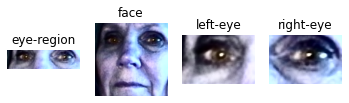

In [45]:
sample = hdf5_dataset[90]
fig = plt.figure()
f, ax = plt.subplots(1, 4)
landmarks = ['eye-region', 'face', 'face-landmarks', 'gaze', 'head', 'left-eye', 'right-eye']



k = 0
for i in range(len(landmarks)):
    x = sample[landmarks[i]]
    if len(x.shape) == 3:
        ax[k].axis('off')
        ax[k].set_title(landmarks[i])
        print(np.max(x))
        ax[k].imshow(np.transpose(x, [1,2,0]))
        k = k + 1




## Trying out batch learning on DataLoader (not Dataset). 

Restart kernel before this step, Kernel->Restart

In [18]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import h5py
import matplotlib
import torch.nn as nn
import torch.optim as optim

In [19]:
#Derived from this discussion: https://discuss.pytorch.org/t/dataloader-when-num-worker-0-there-is-bug/25643/22
#Same old dataset
class HDF5Dataset(Dataset):
    """HDF5Dataset dataset. \
        author: Dusan Svilarkovic
    """

    def __init__(self, hdf_path, transform=None, use_colour = True, data_format = 'NCHW', preprocessing = True):
        """
        Args:
            hdf_path (string): Path to the hdf5 file with annotations.
            transform (callable, optional): Optional transform to be applied
                on a sample.
            use_colour (boolean) : To determine whether dataset has colours or not
            data_format (string) : Type of format used, default is NCHW
            preprocessing (boolean) : Whether we should normalize images or not, usually used during the training
        """
    
        self.hdf_path = hdf_path
        self.landmarks = ['eye-region', 'face', 'face-landmarks', 'gaze', 'head', 'left-eye', 'right-eye']
        self.dataset = None

        #to check if it uses color
        self._use_colour = use_colour
        #at this point useless
        self.data_format = data_format
        
        self.transform = transform
        self.preprocessing = preprocessing

    def __len__(self):
        self.set_dataset_instance()
        return self.person_len * self.samples_per_person_len

    def __getitem__(self, idx):

        self.set_dataset_instance()
        person_id = int(idx / self.samples_per_person_len)
        sample_num = int(idx % self.samples_per_person_len)

        sample = {}
        

        
        for landmark in self.landmarks:
            #looks up in the 
            sample[landmark] = self.dataset.get(self.person_keys[person_id])[landmark][sample_num,]

        if self.preprocessing:
            sample = self.preprocess_entry(sample)
        ## additional metadata, you might need it, might not
        sample['person_id'] = person_id
        sample['sample_num'] = sample_num
            
        if self.transform:
            sample = self.transform(sample)

        return sample
    
    #singleton implementation, in order to avoid opening same dataset again and again
    def set_dataset_instance(self):
        if self.dataset is None:
            self.dataset = h5py.File(self.hdf_path, 'r',libver='latest',swmr=True)
            self.person_keys = list(self.dataset.keys())
            ## number of persons, should be 40
            self.person_len = len(self.dataset)
            ## number of data samples per person, should be 100
            self.samples_per_person_len = self.dataset.get(self.person_keys[0])['face'].shape[0]

    def preprocess_entry(self, entry):
        """Normalize image intensities."""
        for k, v in entry.items():
            if v.ndim == 3:  # We get histogram-normalized BGR inputs
                if not self._use_colour:
                    v = cv.cvtColor(v, cv.COLOR_BGR2GRAY)
                v = v.astype(np.float32)
                v *= 2.0 / 255.0
                v -= 1.0
                if self._use_colour and self.data_format == 'NCHW':
                    v = np.transpose(v, [2, 0, 1])
                elif not self._use_colour:
                    v = np.expand_dims(v, axis=0 if self.data_format == 'NCHW' else -1)
                entry[k] = v

        # Ensure all values in an entry are 4-byte floating point numbers
        for key, value in entry.items():
            entry[key] = value.astype(np.float32)

        return entry


In [21]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

hdf5_dataset = HDF5Dataset(hdf_path='../datasources/data_download/mp19_validation.h5')


In [22]:

##num_workers - number of threads reading from our HDF5Dataset
batch_size = 4
dataloader = DataLoader(hdf5_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=0, pin_memory=True)

n_epochs = 10

for epoch in range(n_epochs):
    for i, batch in enumerate(dataloader):
        print(i)
        print(batch.keys())



0
dict_keys(['eye-region', 'face', 'face-landmarks', 'gaze', 'head', 'left-eye', 'right-eye', 'person_id', 'sample_num'])
1
dict_keys(['eye-region', 'face', 'face-landmarks', 'gaze', 'head', 'left-eye', 'right-eye', 'person_id', 'sample_num'])
2
dict_keys(['eye-region', 'face', 'face-landmarks', 'gaze', 'head', 'left-eye', 'right-eye', 'person_id', 'sample_num'])
3
dict_keys(['eye-region', 'face', 'face-landmarks', 'gaze', 'head', 'left-eye', 'right-eye', 'person_id', 'sample_num'])
4
dict_keys(['eye-region', 'face', 'face-landmarks', 'gaze', 'head', 'left-eye', 'right-eye', 'person_id', 'sample_num'])
5
dict_keys(['eye-region', 'face', 'face-landmarks', 'gaze', 'head', 'left-eye', 'right-eye', 'person_id', 'sample_num'])
6
dict_keys(['eye-region', 'face', 'face-landmarks', 'gaze', 'head', 'left-eye', 'right-eye', 'person_id', 'sample_num'])
7
dict_keys(['eye-region', 'face', 'face-landmarks', 'gaze', 'head', 'left-eye', 'right-eye', 'person_id', 'sample_num'])
8
dict_keys(['eye-region

KeyboardInterrupt: 

## Making of dummy model for training on these files

In [23]:
sample = hdf5_dataset[90]
for key in hdf5_dataset.landmarks:
    print(key, sample[key].shape)

eye-region (3, 60, 224)
face (3, 224, 224)
face-landmarks (33, 2)
gaze (2,)
head (2,)
left-eye (3, 60, 90)
right-eye (3, 60, 90)


### Face Landmarks only (need to use 'head', but don't know when and how) 


In [24]:
class LandmarkUnit(nn.Module):
    def __init__(self, feature_size = 66, output_size = 2, device = 'cuda'):
        super(LandmarkUnit, self).__init__()

        self.device = device
        self.feature_size = feature_size
        self.fc1 = nn.Linear(feature_size, int(feature_size/2))  
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(int(feature_size/2), int(feature_size/2))

        self.fc3 = nn.Linear(int(feature_size/2), int(feature_size/4))

        self.fc5 = nn.Linear(int(feature_size/4), 2)




    def forward(self, x):
        batch_size, feature_size, dim = x['face-landmarks'].size()
        x = x['face-landmarks'].view(batch_size, -1).float().to(self.device)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc5(x)
        return x

In [25]:
batch = next(iter(dataloader))

In [26]:
device

device(type='cuda', index=0)

In [27]:
landmarkUnit = LandmarkUnit(device = device).to(device)
print(landmarkUnit)
landmarkUnit(batch).shape

LandmarkUnit(
  (fc1): Linear(in_features=66, out_features=33, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=33, out_features=33, bias=True)
  (fc3): Linear(in_features=33, out_features=16, bias=True)
  (fc5): Linear(in_features=16, out_features=2, bias=True)
)


torch.Size([4, 2])

### All images only

In [28]:
#Inspiration from https://people.csail.mit.edu/khosla/papers/cvpr2016_Khosla.pdf
class ImageUnit(nn.Module):
    """
        Image unit neural network for extracting important images from dictionary. \n
        Those are: eye-region, face, left-eye, right-eye. \n
        
        inputs:
            sample_dictionary (dictionary) : used for extracting shape sizes and setting up adequate convolutional \n
            network sizes
    """
    def __init__(self, sample_dictionary):
        super(ImageUnit, self).__init__()
        
        self.eye_region_height, self.eye_region_width, _ = sample_dictionary['eye-region'].shape
        self.one_eye_height, self.one_eye_width, _ = sample_dictionary['left-eye'].shape
        self.face_height, self.face_width, _ = sample_dictionary['face'].shape
        

        
        
     
        #Left and right eye shared weights
        self.conv_e1 = nn.Conv2d(in_channels=3, out_channels=96, kernel_size=(11,11), stride=1, padding= (1, 1))
        self.conv_e2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=(5,5), stride=1, padding= (1, 1))
        self.conv_e3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=(3,3), stride=1, padding=(1, 1))
        self.conv_e4 = nn.Conv2d(in_channels=384, out_channels=64, kernel_size=(1,1), stride=1, padding=(1, 1))
        
        # fc for connecting left and right eye
        self.fc_e1 = nn.Linear(2 * 64 * 7 * 10, 128)
        

        # Face weights
        self.conv_f1 = nn.Conv2d(in_channels=3, out_channels=96, kernel_size=(11,11), stride=1, padding= (1, 1))
        self.conv_f2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=(5,5), stride=1, padding= (1, 1))
        self.conv_f3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=(3,3), stride=1, padding=(1, 1))
        self.conv_f4 = nn.Conv2d(in_channels=384, out_channels=64, kernel_size=(1,1), stride=1, padding=(1, 1))

        #paper doesn't have this file, kinda funny
        self.conv_f5 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(1,1), stride=1, padding=(1, 1))

        
        # fc for face weights
        self.fc_f1 = nn.Linear(64 * 7 * 7, 128)
        self.fc_f2 = nn.Linear(128, 64)
        
        #finally , for the output
        
        #fc-f2 + fc-e1 + maybe fc-fg1 (input and face masks needs to be reconsidered)
        self.fc1 = nn.Linear(64 + 128, 128)
        self.fc2 = nn.Linear(128, 2)
        
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2)

        
    def forward(self,landmark):
        batch_size, _, _, _= landmark['eye-region'].shape
        #left eye
        left_eye = self.forward_eye(landmark['left-eye'])
        
        #right eye
        right_eye = self.forward_eye(landmark['right-eye'])

        
        #left_eye + right_eye
        eyes = torch.cat([left_eye, right_eye], dim=1)
        eyes = eyes.view(batch_size, -1)
        fc_e1 = self.fc_e1(eyes)
        fc_e1 = self.relu(fc_e1)
        
        #face
        face = self.forward_face(landmark['face'])
        
        #fc1 and fc2 with face + fc_f1 connected

        face_and_eyes = torch.cat([face, fc_e1], dim = 1)
        
        output = self.fc1(face_and_eyes)
        output = self.relu(output)
        output = self.fc2(output)
        
        
        return output
    
    def forward_eye(self, x):
        """Used for taking either right-eye or left-eye for forwarding. \n
        Using shared weights as in the paper referenced"""
        
#         x = x.permute(0,3,1,2).float()
        x = x.float().to
    
        x = self.conv_e1(x)
        x = self.relu(x)
        x = self.pool(x)
        
        x = self.conv_e2(x)
        x = self.relu(x)
        x = self.pool(x)
        
        x = self.conv_e3(x)
        x = self.relu(x)
        x = self.pool(x)
        
        x = self.conv_e4(x)
        x = self.relu(x)
        return x
    
    def forward_face(self, x):
        batch_size = x.shape[0]
#         x = x.permute(0,3,1,2).float()
        x = x.float()
        x = self.conv_f1(x)
        x = self.relu(x)
        x = self.pool(x)
        
        x = self.conv_f2(x)
        x = self.relu(x)
        x = self.pool(x)
        
        x = self.conv_f3(x)
        x = self.relu(x)
        x = self.pool(x)
        
        x = self.conv_f4(x)
        x = self.relu(x)
        x = self.pool(x)
        
        x = self.conv_f5(x)
        x = self.relu(x)
        x = self.pool(x)
        
        x = self.fc_f1(x.view(batch_size, -1))
        x = self.relu(x)
        x = self.fc_f2(x)
        x = self.relu(x)
        
        return x

In [29]:
batch['eye-region'].shape

torch.Size([4, 3, 60, 224])

In [30]:
image_unit = ImageUnit(sample).to(device)

In [31]:
batch = next(iter(dataloader))

In [32]:
for key in batch.keys():
    batch[key] = batch[key].to(device) 
print(batch)

{'eye-region': tensor([[[[ 0.8980,  0.8667,  0.7490,  ...,  0.5294,  0.6627,  0.7098],
          [ 0.8353,  0.7804,  0.6157,  ...,  0.6235,  0.6941,  0.7569],
          [ 0.8039,  0.7490,  0.6627,  ...,  0.7020,  0.7647,  0.7882],
          ...,
          [ 0.4510,  0.3725,  0.1922,  ...,  0.8824,  0.8824,  0.8824],
          [ 0.4510,  0.3725,  0.1922,  ...,  0.8745,  0.8745,  0.8824],
          [ 0.3725,  0.2941,  0.1922,  ...,  0.8667,  0.8667,  0.8824]],

         [[ 0.8745,  0.8431,  0.7098,  ...,  0.6157,  0.7490,  0.8196],
          [ 0.8118,  0.7412,  0.5765,  ...,  0.7098,  0.7804,  0.8431],
          [ 0.7804,  0.7098,  0.6235,  ...,  0.7725,  0.8353,  0.8745],
          ...,
          [ 0.4510,  0.3725,  0.1922,  ...,  1.0000,  1.0000,  1.0000],
          [ 0.4510,  0.3725,  0.1922,  ...,  1.0000,  1.0000,  1.0000],
          [ 0.3725,  0.2941,  0.1922,  ...,  0.9922,  0.9922,  1.0000]],

         [[ 1.0000,  1.0000,  0.9608,  ...,  0.8353,  0.9686,  1.0000],
          [ 1.0

In [49]:
print(image_unit)
for key in batch.keys():
    batch[key] = batch[key].to(device) 
image_unit(batch).shape

#doesn't work on this pne

ImageUnit(
  (conv_e1): Conv2d(3, 96, kernel_size=(11, 11), stride=(1, 1), padding=(1, 1))
  (conv_e2): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv_e3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_e4): Conv2d(384, 64, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
  (fc_e1): Linear(in_features=8960, out_features=128, bias=True)
  (conv_f1): Conv2d(3, 96, kernel_size=(11, 11), stride=(1, 1), padding=(1, 1))
  (conv_f2): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv_f3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_f4): Conv2d(384, 64, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
  (conv_f5): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
  (fc_f1): Linear(in_features=3136, out_features=128, bias=True)
  (fc_f2): Linear(in_features=128, out_features=64, bias=True)
  (fc1): Linear(in_features=192, out_features=128, bias=True)
  (fc2): Line

torch.Size([4, 2])

## Connecting two models, for landmarks and images

In [36]:
class MultiModalUnit(nn.Module):

    def __init__(self, sample_dictionary, feature_size = 66, output_size = 2, device = 'cuda'):
        super(MultiModalUnit, self).__init__()        

        self.device = device
        self.landmark_unit = LandmarkUnit(device = device).to(device)
        self.image_unit = ImageUnit(sample_dictionary).to(device)
        
        self.fc_final_f1 = nn.Linear(4, 16)
        self.relu = nn.ReLU()
        self.fc_final_f2 = nn.Linear(16, 2)
        
    def forward(self, x):
        landmark_unit_output = self.landmark_unit(x)
        image_unit_output = self.image_unit(x)
        
        x = self.fc_final_f1(torch.cat([landmark_unit_output, image_unit_output], dim = 1))
        x = self.relu(x)
        x = self.fc_final_f2(x)
        
        return x
        

In [37]:
multimodal_unit = MultiModalUnit(sample,device = device).to(device)

In [48]:
for key in batch.keys():
    batch[key] = batch[key].to(device) 
multimodal_unit(batch).shape

torch.Size([4, 2])

In [39]:
sample.keys()

dict_keys(['eye-region', 'face', 'face-landmarks', 'gaze', 'head', 'left-eye', 'right-eye', 'person_id', 'sample_num'])

## "Training"

Note that this print in the output was just retraining on the same batch, I commented out for i, batch in enumerate(dataloader):

In [47]:

dataloader = DataLoader(hdf5_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=0)

n_epochs = 100

multimodal_unit = MultiModalUnit(sample).to(device)
loss_fn = torch.nn.MSELoss(reduction='sum')
learning_rate = 1e-4
optimizer = torch.optim.Adam(multimodal_unit.parameters(), lr=learning_rate)

for epoch in range(n_epochs):
    for i, batch in enumerate(dataloader): 
        for key in batch.keys():
            batch[key] = batch[key].to(device) 

        y_pred = multimodal_unit(batch)

        loss = loss_fn(y_pred, batch['gaze'])

        optimizer.zero_grad()

        # Backward pass: compute gradient of the loss with respect to model
        # parameters
        loss.backward()

        # Calling the step function on an Optimizer makes an update to its
        # parameters
        optimizer.step()

        print(loss.item())


7.205007076263428
6.758833408355713
6.330598831176758
5.909714698791504
5.495427131652832
5.088781356811523
4.68016242980957
4.277421951293945
3.8780689239501953
3.491823434829712
3.1007134914398193
2.714264392852783
2.3173987865448
1.9528424739837646
1.5008654594421387
1.1373242139816284
0.9199979305267334
0.5967532992362976
0.3060039281845093
0.16440290212631226
0.16800786554813385
0.177358478307724
0.1842176467180252
0.20095066726207733
0.21702444553375244
0.23067036271095276
0.22997821867465973
0.22387410700321198
0.22555798292160034
0.23031295835971832
0.23117825388908386
0.22270357608795166
0.21236979961395264
0.20440185070037842
0.19756318628787994
0.19079191982746124
0.18183493614196777
0.17136037349700928
0.16410359740257263
0.1617322862148285
0.15865865349769592
0.15455466508865356
0.1507505476474762
0.1482815146446228
0.146629199385643
0.14421522617340088
0.14077447354793549
0.13706569373607635
0.13400404155254364
0.13166454434394836
0.12921276688575745
0.12641140818595886
0

KeyboardInterrupt: 

## Comparing speed of reading npz files instead of hdf5 (maybe)